<a href="https://colab.research.google.com/github/mritogether/ESMRMB2024_Hardware_to_Map/blob/main/02_sequence_design_for_mapping/notebooks/s00_fid_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# s00_fid (exercise)
FID is the simpliest sequence but this does not mean it is not important:) Now, let's build FID together and kick off the Pulseq game in Colab!    
     
**Exercise**           
If you have no clue, search "hint" for hints.
1. Go through the whole sequence source code and then run it to get familiar with Pulseq programming in Google CoLab.
2. Observe the simulated signal and the reconstructed spectrum. Why do we see only a decay and not a damped oscillation in the simulated signal? Increase the number of ADC samples (nRD) and ADC duration (sampling_time), and see the prolonged signal decay.   
3. Is the decay of the FID given by T1, T2, or T2*? Estimate the numerical value of the decay rate R (or relaxation time T=1/R) of the FID signal.
4. Change the echo time (TE) to 15 ms and repetition time (TR) to 300 ms.
5. (Optional) Search for the B0 inhomogeneity of the object (dB0). In the on-resonant case this is 0. By changing the value (e.g. dB0 = 500), you can mimic the laboratory frame dynamic and observe a frequency shift in the reconstructed 1D spectrum.
6. (Optional) Set dB0=0 and alter the RF phase offset and ADC phase offset. What do you observe? What is the most general condition to get a real positive signal?

In [ ]:
#@title FID - environment setup (just need to run it once)
!pip show pypulseq || pip install pypulseq &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as pp
# for simulation
!pip show MRzeroCore || pip install MRzeroCore
import MRzeroCore as mr0
import torch

/usr/local/lib/python3.10/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:

Failed to import CuPy.

If you installed CuPy via wheels (cupy-cudaXXX or cupy-rocm-X-X), make sure that the package matches with the version of CUDA or ROCm installed.

On Linux, you may need to set LD_LIBRARY_PATH environment variable depending on how you installed CUDA/ROCm.
On Windows, try setting CUDA_PATH environment variable.

Check the Installation Guide for details:
  https://docs.cupy.dev/en/latest/install.html

Original error:
  ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

  warnings.warn(


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.5/454.5 kB 25.5 MB/s eta 0:00:00


TR fill: 295.70000000000005 ms
Timing check passed successfully


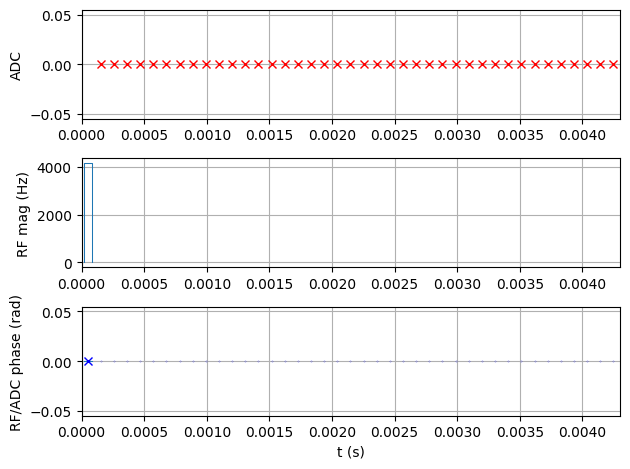

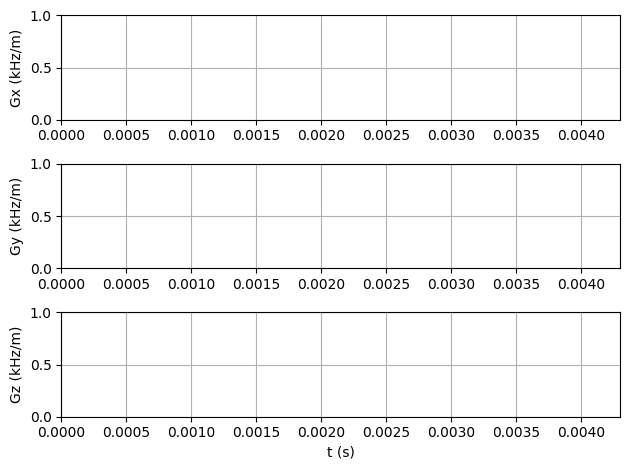

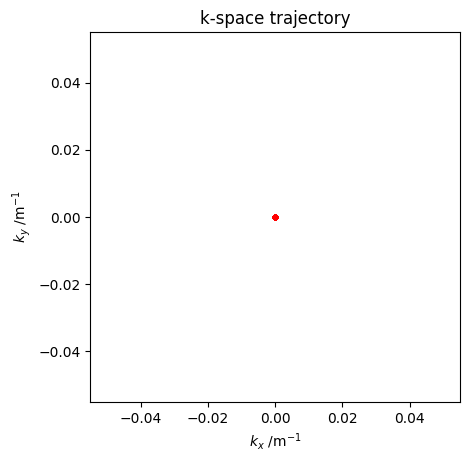

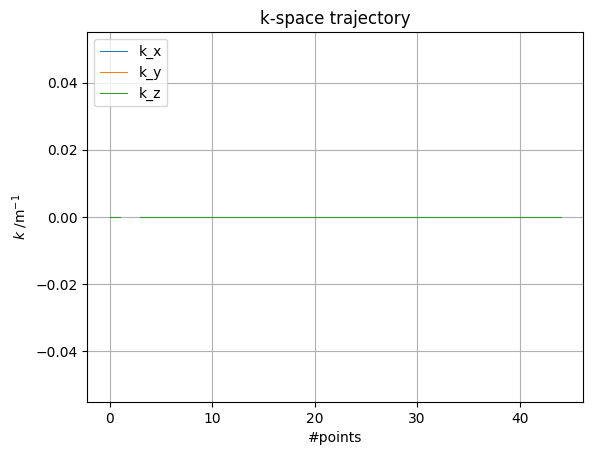

'3f31ba79a85975afb6f8c6b5ca026ea8'

In [ ]:
#@title FID - sequence
experiment_id = 's00_fid'
# %% SETUP system
# choose the scanner limits
system = pp.Opts(
        max_grad=25,       # the portable scanner's limits are 25, 40 and 35 mT/m for X, Y and Z axes
        grad_unit="mT/m",
        max_slew=50,       # the portable scanner's limits are 50, 80 and 70 mT/m/ms for X, Y and Z, respectively
        slew_unit="T/m/s",
        rf_ringdown_time=15e-6,
        rf_dead_time=15e-6,
        adc_dead_time=0e-6 )
# Create a new sequence object
seq = pp.Sequence(system)

# %% DEFINE the sequence and parameters
nRD = 40     # Number of ADC samples
TE = 15e-3 # Echo time
TR = 300e-3  # Repetition time

sampling_time = 4.2e-3
t_ex  = 60e-6 # [s], duration of the excitation pulse.
rf_ex_phase = 0 #np.pi / 2 # phase of the excitation pulse # hint: alter the phase offset of the excitation pulse here

# derived and modifed parameters
TE = round(TE/system.grad_raster_time/2) * system.grad_raster_time * 2 # TE should be divisible to a double gradient raster, which simplifies calcuations
rf_add = math.ceil(max(system.rf_dead_time,system.rf_ringdown_time)/system.grad_raster_time)*system.grad_raster_time # round up dead times to the gradient raster time to enable correct TE calculation

# ======
# CREATE EVENTS
# ======

# excitation pulse
flip_ex = 90 * np.pi / 180
rf_ex = pp.make_block_pulse(
    flip_angle=flip_ex,
    system=system,
    duration=t_ex,
    delay=rf_add,
    phase_offset=rf_ex_phase )

d_ex=pp.make_delay(t_ex+rf_add*2)

adc_delay = system.grad_raster_time * np.round((TE-t_ex/2-rf_add) / system.grad_raster_time)
adc = pp.make_adc(
    num_samples=nRD,
    dwell=sampling_time/nRD,
    delay=0 ) # Hint: change the delay of adc to alter TE

# Fill-times
t_ex = pp.calc_duration(d_ex) # Duration of the excitation pulse object (Deadtime + duration + ringdowntime)
t_adc = pp.calc_duration(adc) # Duration of the ADC event (delay+num_samples*dwell)

TR_fill = TR - t_ex - t_adc
# Round to gradient raster
TR_fill = system.grad_raster_time * np.round(TR_fill / system.grad_raster_time)
if TR_fill < 0:
    TR_fill = 1e-3
    warnings.warn(
        f"TR too short, adapted to: {1000 * (t_ex + t_adc + TR_fill)} ms"
    )
else:
    print(f"TR fill: {1000 * TR_fill} ms")
delay_TR = pp.make_delay(TR_fill)

# ======
# CONSTRUCT SEQUENCE
# ======
seq.add_block(rf_ex, d_ex)
seq.add_block(adc)
# Hint: Add delay_TR event here to make TR = 300 ms

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# ======
# VISUALIZATION
# ======
seq.plot(time_range=(0, TR))

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1], 'b-')
plt.plot(k_traj_adc[0],k_traj_adc[1],'r.')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.title('k-space trajectory')
plt.xlabel(r'$k_x \mathregular{\ /m^{-1}}$')
plt.ylabel(r'$k_y \mathregular{\ /m^{-1}}$')
plt.show()

plt.figure()
p1 = plt.plot(k_traj[0], label='k_x')
p2 = plt.plot(k_traj[1], label='k_y')
p3 = plt.plot(k_traj[2], label='k_z')
plt.legend(loc="upper left")
plt.xlabel('#points')
plt.ylabel('$k \mathregular{\ /m^{-1}}$')
ax = plt.gca()
ax.grid();
plt.title('k-space trajectory')
plt.show()

# Prepare the sequence output for the scanner
seq.set_definition('Name', experiment_id)
seq.write(experiment_id+'.seq')

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


CustomVoxelPhantom
Voxel shape: box
Voxel size: tensor([0.1000, 0.1000, 0.1000])


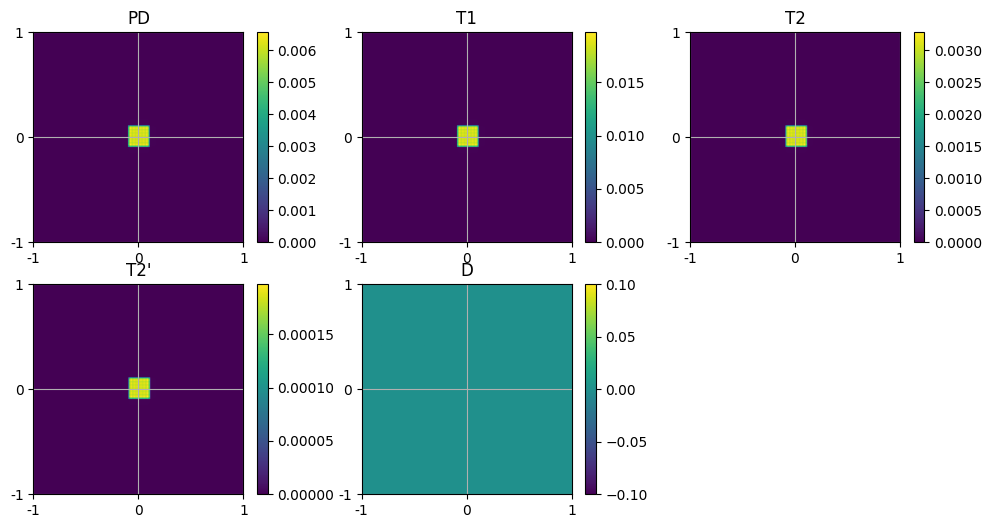

In [ ]:
#@title 1D FID in a pixel phantom - simulation
dB0 = 0 # hint: change dB0 here
obj_p = mr0.CustomVoxelPhantom(
        pos=[[0., 0., 0]],
        PD=[1.0],
        T1=[3.0],
        T2=[0.5],
        T2dash=[30e-3],
        D=[0.0],
        B0=0,
        voxel_size=0.1,
        voxel_shape="box"
    )
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

Text(0, 0.5, 'Amplitude')

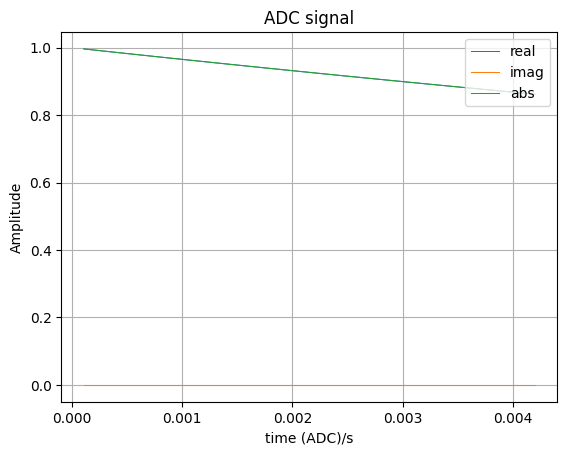

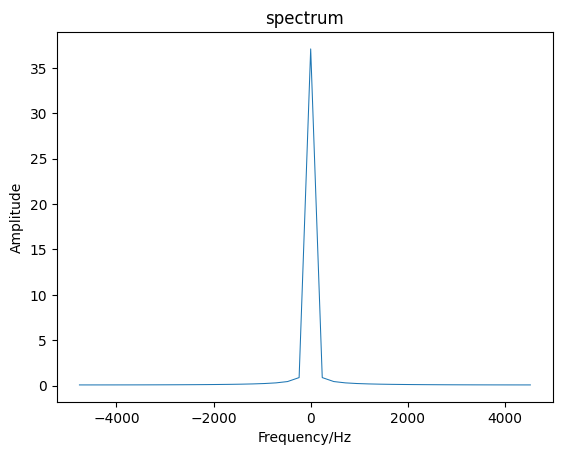

In [ ]:
#@title 1D FID in a pixel phantom - reconstruction
# 1D FFT
def fft_1d(x):
    return np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(x)))

# detailed ADC plot for one repetition
plt.figure()
plt.title('ADC signal')
# time axis
time_axis=np.linspace(1, nRD, nRD)*adc.dwell ;
plt.plot(time_axis, np.real(signal), label='real')
plt.plot(time_axis, np.imag(signal), label='imag')
plt.plot(time_axis, np.abs(signal), label='abs')
plt.grid()
plt.legend(loc="upper right")
plt.xlabel('time (ADC)/s')
plt.ylabel('Amplitude')

# FFT reconstruction
spectrum = fft_1d(signal)

# frequency axis
freq_axis = np.linspace(-nRD/2, nRD/2-1, nRD)/(adc.dwell*adc.num_samples) ; # remain to be checked whether -1 should be included or not

plt.figure()
plt.title('spectrum')
plt.plot(freq_axis, np.abs(spectrum))
plt.xlabel('Frequency/Hz')
plt.ylabel('Amplitude')